#Zasoby

* Single time-series forecasting from Google Analytics data

* https://cloud.google.com/bigquery/docs/e2e-journey
* https://cloud.google.com/bigquery/docs/arima-single-time-series-forecasting-tutorial
* https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-time-series

#Cele

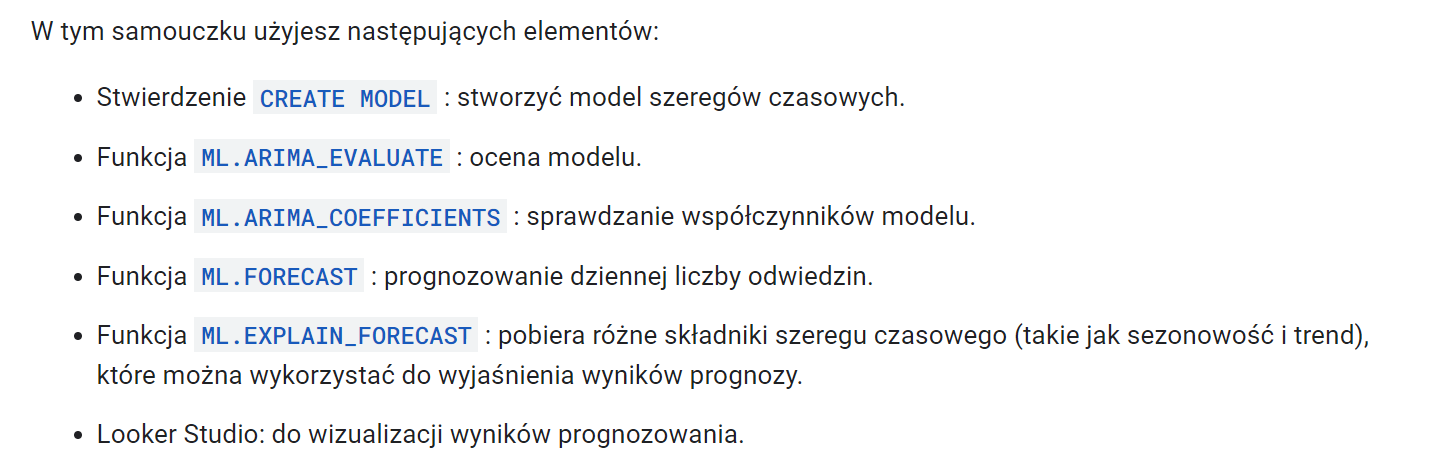

#Wizualizuj szeregi czasowe, które chcesz prognozować (Krok 1)

In [ ]:
%%bigquery

SELECT
  PARSE_TIMESTAMP("%Y%m%d", date) AS parsed_date,
  SUM(totals.visits) AS total_visits
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
GROUP BY date

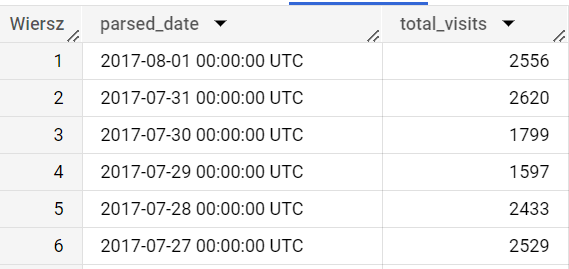

#Utwórz model szeregów czasowych (Krok 2)

In [ ]:
%%bigquery

  {CREATE MODEL | CREATE MODEL IF NOT EXISTS | CREATE OR REPLACE MODEL}
model_name
OPTIONS(MODEL_TYPE = 'ARIMA_PLUS'
  [, TIME_SERIES_TIMESTAMP_COL = string_value ] # Nazwa kolumny sygnatury czasowej dla modeli szeregów czasowych.
  [, TIME_SERIES_DATA_COL = string_value ] # Nazwa kolumny danych dla modeli szeregów czasowych.
  [, TIME_SERIES_ID_COL = { string_value | string_array } ]
  [, HORIZON = int64_value ]

  # Domyślnie, auto_arima=TRUE więc auto.ARIMA algorytm automatycznie dostraja hiperparametry w ARIMA_PLUS modelach
  [, AUTO_ARIMA = { TRUE | FALSE } ]

  [, AUTO_ARIMA_MAX_ORDER = int64_value ]
  [, NON_SEASONAL_ORDER = (int64_value, int64_value, int64_value) ]

  # Częstotliwość danych wejściowych szeregów czasowych. Najdrobniejsza obsługiwana szczegółowość to 'PER_MINUTE'
  [, DATA_FREQUENCY = { 'AUTO_FREQUENCY' | 'PER_MINUTE' | 'HOURLY' | 'DAILY' | 'WEEKLY' | 'MONTHLY' | 'QUARTERLY' | 'YEARLY' } ]

  [, INCLUDE_DRIFT = { TRUE | FALSE } ]
  [, HOLIDAY_REGION = string_value | string_array ]
  [, CLEAN_SPIKES_AND_DIPS = { TRUE | FALSE } ]
  [, ADJUST_STEP_CHANGES = { TRUE | FALSE } ]

  # Efekt wakacji i składniki sezonowe)
  [, DECOMPOSE_TIME_SERIES = { TRUE | FALSE } ]

  [, TIME_SERIES_LENGTH_FRACTION = float64_value ]
  [, MIN_TIME_SERIES_LENGTH = int64_value ]
  [, MAX_TIME_SERIES_LENGTH = int64_value ]
  [, TREND_SMOOTHING_WINDOW_SIZE = int64_value ]
  [, SEASONALITIES = string_array ])
[AS {query_statement |
  (
    training_data AS (query_statement),
    custom_holiday AS (holiday_statement)
  )}]

In [ ]:
%%bigquery

#standardSQL
CREATE OR REPLACE MODEL bqml_tutorial.ga_arima_model
OPTIONS
  (model_type = 'ARIMA_PLUS',
   time_series_timestamp_col = 'parsed_date',
   time_series_data_col = 'total_visits',
   auto_arima = TRUE,
   data_frequency = 'AUTO_FREQUENCY',
   decompose_time_series = TRUE
  ) AS

SELECT
  PARSE_TIMESTAMP("%Y%m%d", date) AS parsed_date,
  SUM(totals.visits) AS total_visits
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
GROUP BY date

In [ ]:
%%bigquery

CREATE OR REPLACE MODEL pmackowka_us.model_0122
OPTIONS
  (model_type = 'ARIMA_PLUS',
   time_series_timestamp_col = 'parsed_date',
   time_series_data_col = 'total_visits',
   auto_arima = TRUE,
   data_frequency = 'AUTO_FREQUENCY',
   decompose_time_series = TRUE,
   HOLIDAY_REGION = 'US'
  ) AS

SELECT
  PARSE_TIMESTAMP("%Y%m%d", date) AS parsed_date,
  SUM(totals.visits) AS total_visits
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
GROUP BY date

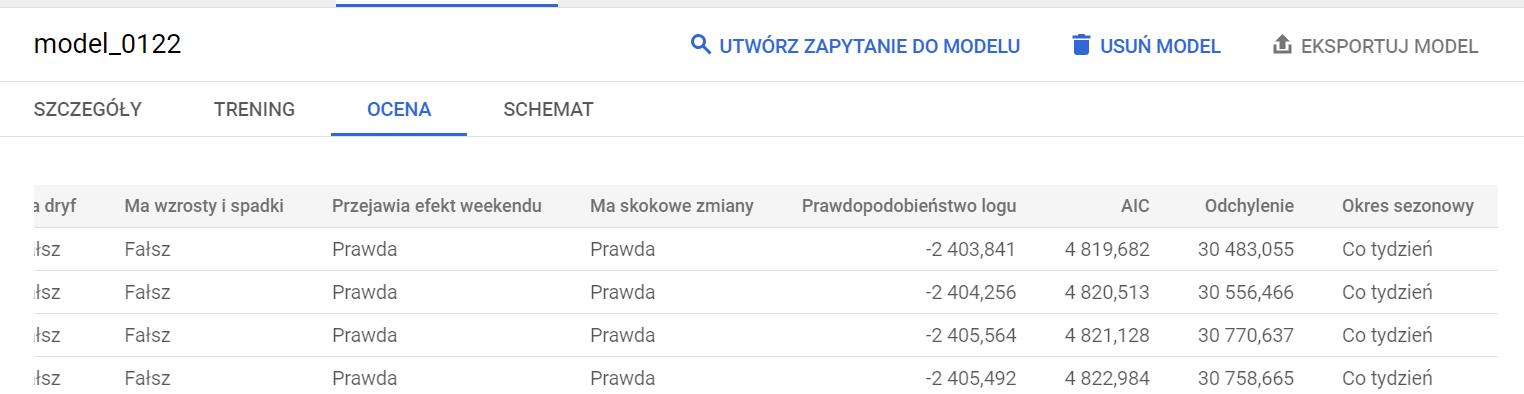

# Sprawdź metryki oceny wszystkich ocenianych modeli (Krok 3)

In [ ]:
%%bigquery

SELECT
 *
FROM
 ML.ARIMA_EVALUATE(MODEL pmackowka_us.model_0122)

* Poniższe cztery kolumny ( `non_seasonal_{p,d,q} i has_drift` ) definiują model ARIMA w potoku szkoleniowym.

* Trzy kolejne metryki ( `log_likelihood, AIC i variance`) są istotne dla procesu dopasowywania modelu ARIMA.

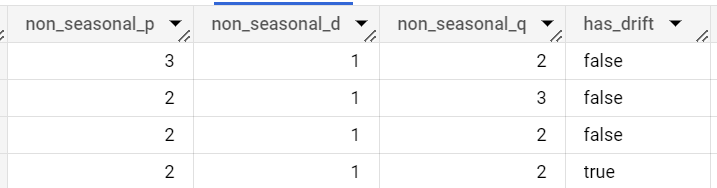

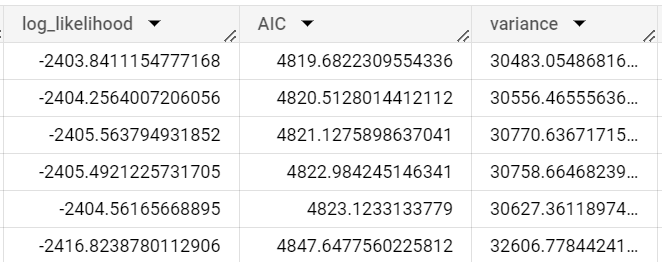

* Model w pierwszym rzędzie ma najniższy AIC i jest uważany za najlepszy model. Ten najlepszy model jest zapisywany jako model ostateczny i używany podczas wywoływania poleceń `ML.EXPLAIN_FORECAST, ML.FORECAST i ML.ARIMA_COEFFICIENTS`, jak pokazano w poniższych krokach.

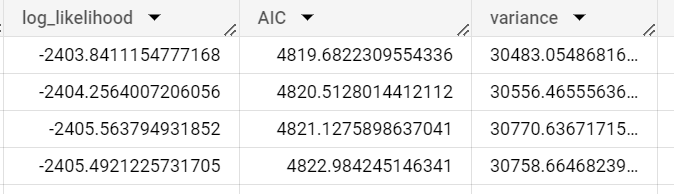

# Sprawdź współczynniki swojego modelu (Krok 4)

* Funkcja `ML.ARIMA_COEFFICIENTS` pobiera współczynniki Twojego modelu ARIMA_PLUS

In [ ]:
%%bigquery

SELECT
 *
FROM
 ML.ARIMA_COEFFICIENTS(MODEL pmackowka_us.model_0122)

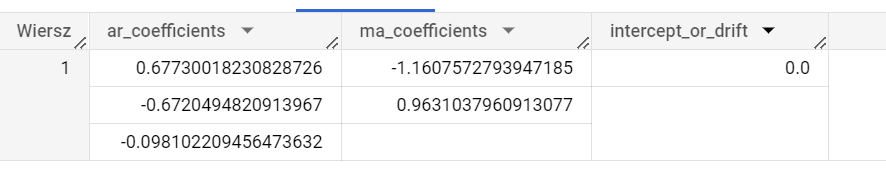

#Użyj modelu do prognozowania szeregów czasowych (Krok 5)

* Funkcja `ML.FORECAST` prognozuje przyszłe wartości szeregów czasowych z przedziałem predykcji przy użyciu modelu: `pmackowka_us.model_0122`.

* Dane historyczne kończą się na `2017-08-01 00:00:00 UTC`

* Predykcja zaczyna się na `2017-08-02 00:00:00 UTC`

* W poniższym zapytaniu `STRUCT(30 AS horizon, 0.8 AS confidence_level)` klauzula wskazuje, że zapytanie prognozuje 30 przyszłych punktów czasowych i generuje przedział przewidywania z poziomem ufności 80%.

In [ ]:
%%bigquery

SELECT
 *
FROM
 ML.FORECAST(MODEL pmackowka_us.model_0122,
             STRUCT(30 AS horizon, 0.8 AS confidence_level))

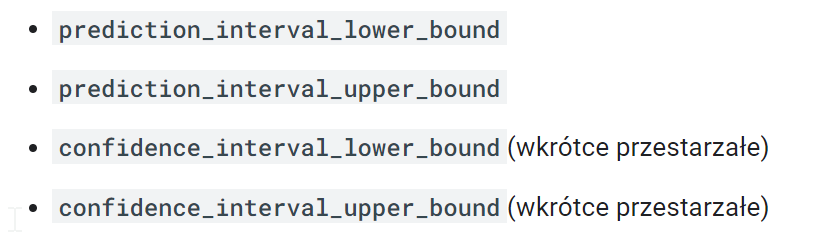

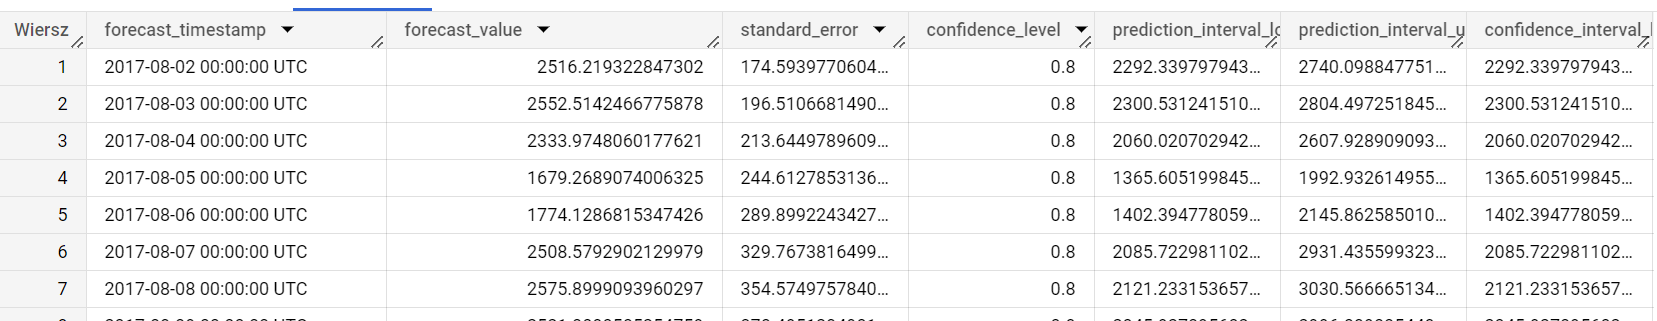

#Wyjaśnij i zwizualizuj wyniki prognozowania (Krok 6)

* Wsad do Looker Studio

* Funkcja `ML.EXPLAIN_FORECAST` prognozuje przyszłe wartości szeregów czasowych z przedziałem predykcji przy użyciu modelu `pmackowka_us.model_0122` jednocześnie zwraca wszystkie oddzielne składniki szeregu czasowego.

In [ ]:
%%bigquery

SELECT
 *
FROM
 ML.EXPLAIN_FORECAST(MODEL pmackowka_us.model_0122,
                     STRUCT(30 AS horizon, 0.8 AS confidence_level))

order by time_series_timestamp desc

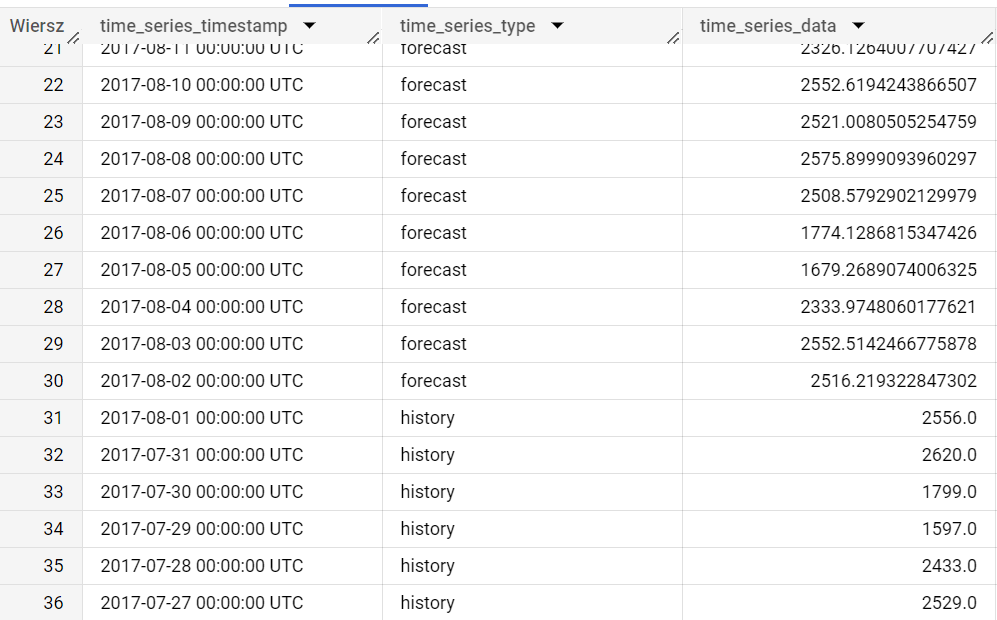

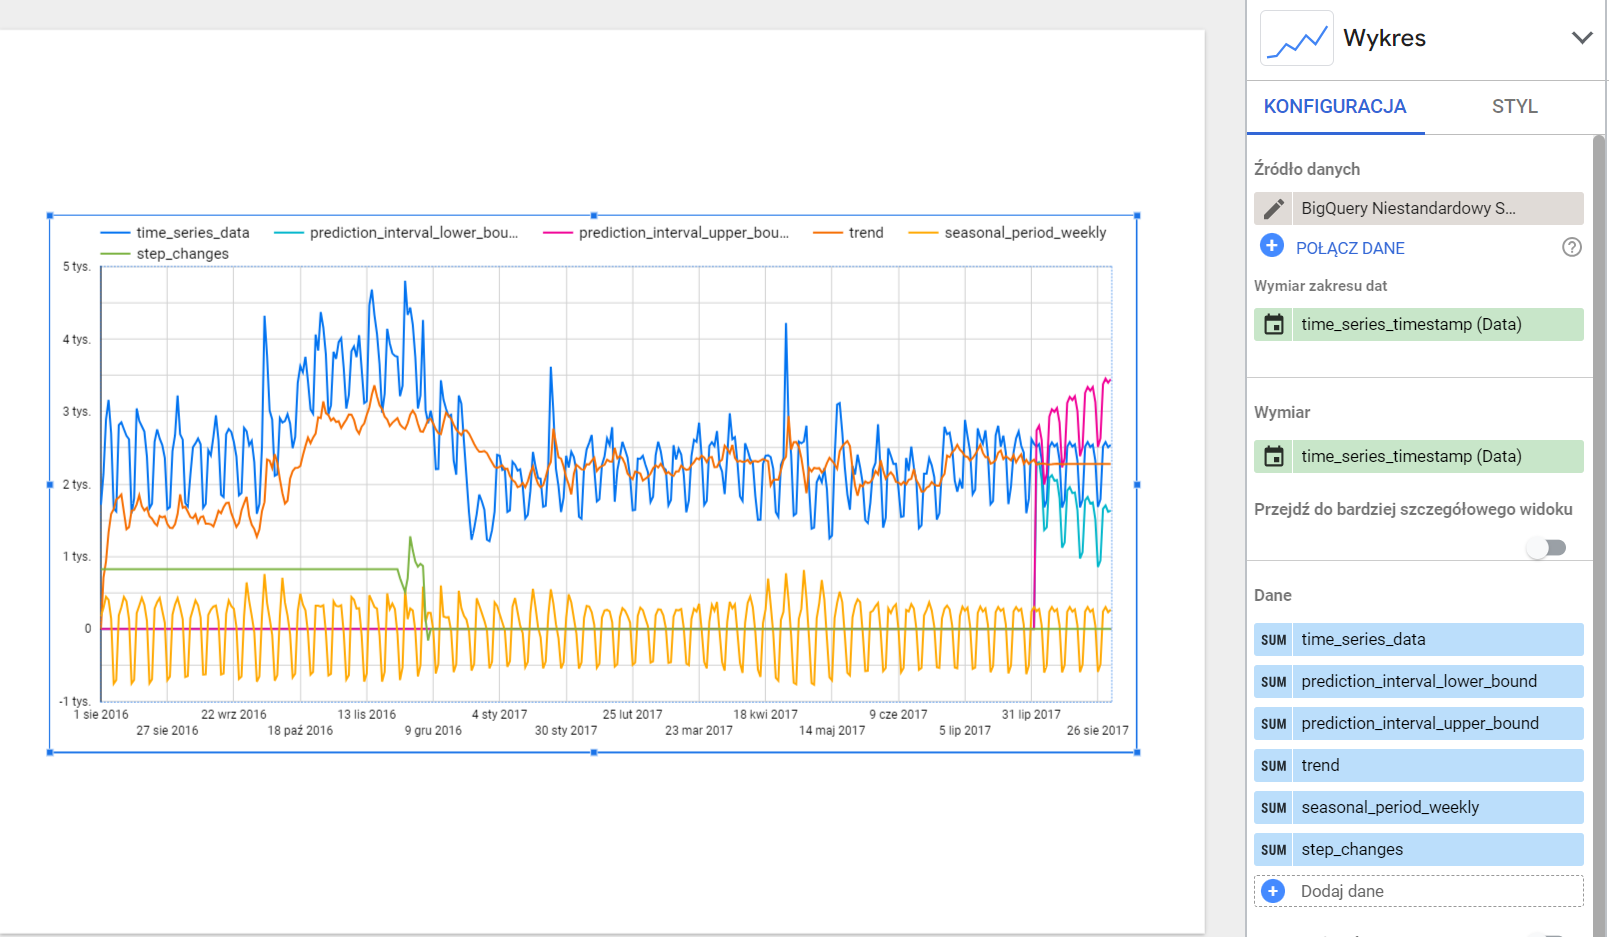

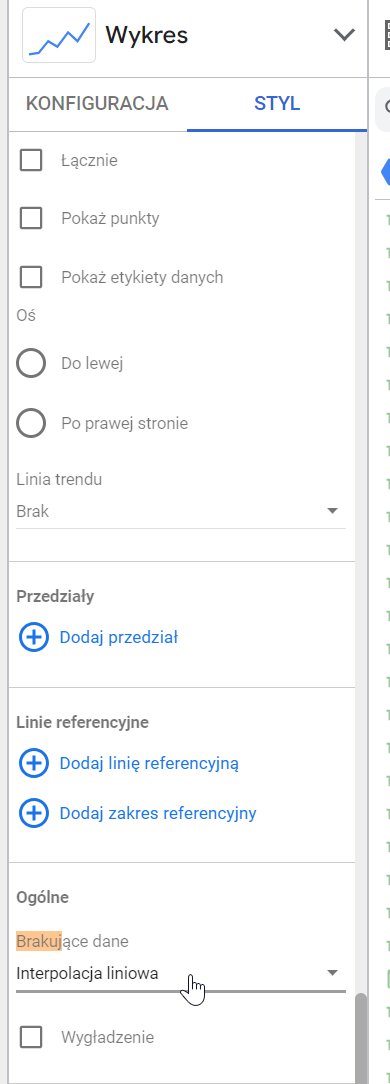

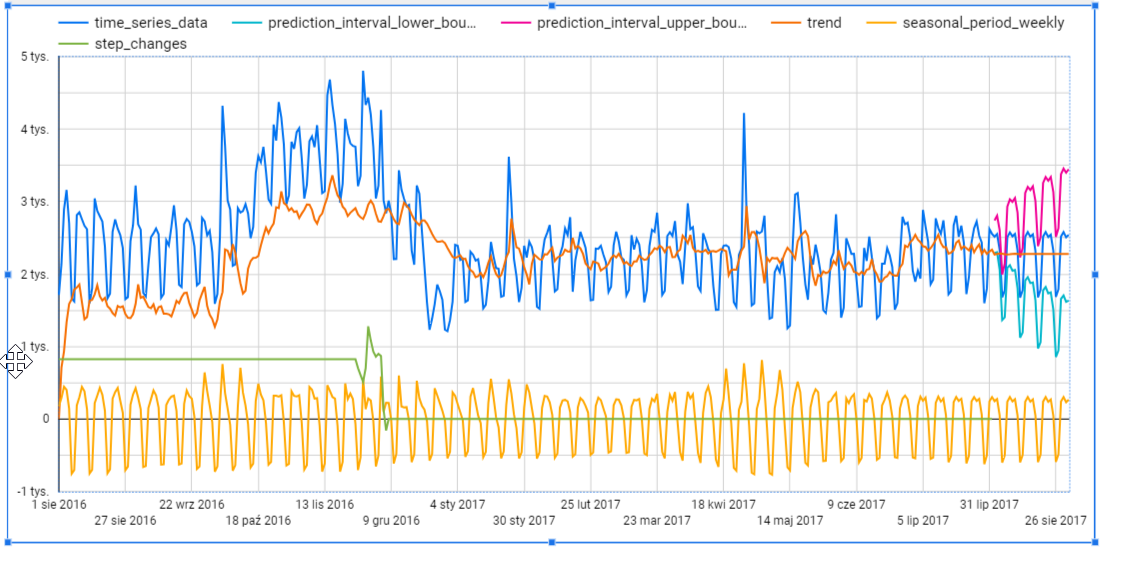

#Wizualizuj wyniki prognozowania bez włączania `decompose_time_series` (Krok 7)

* Jeśli `decompose_time_series` w szkoleniu ustawiono wartość `false` ARIMA_PLUS, można połączyć szeregi czasowe historii i prognozowane szeregi czasowe, korzystając z UNION ALL klauzuli i `ML.FORECAST` funkcji.

In [ ]:
%%bigquery

SELECT
 history_timestamp AS timestamp,
 history_value,
 NULL AS forecast_value,
 NULL AS prediction_interval_lower_bound,
 NULL AS prediction_interval_upper_bound
FROM
 (
   SELECT
     PARSE_TIMESTAMP("%Y%m%d", date) AS history_timestamp,
     SUM(totals.visits) AS history_value
   FROM
     `bigquery-public-data.google_analytics_sample.ga_sessions_*`
   GROUP BY date
   ORDER BY date ASC
 )
UNION ALL
SELECT
 forecast_timestamp AS timestamp,
 NULL AS history_value,
 forecast_value,
 prediction_interval_lower_bound,
 prediction_interval_upper_bound
FROM
 ML.FORECAST(MODEL pmackowka_us.model_0122,
             STRUCT(30 AS horizon, 0.8 AS confidence_level))

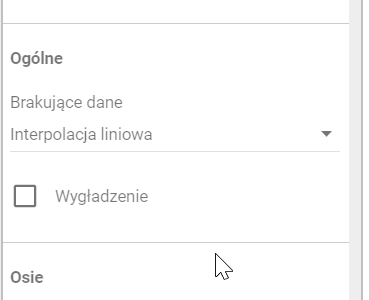

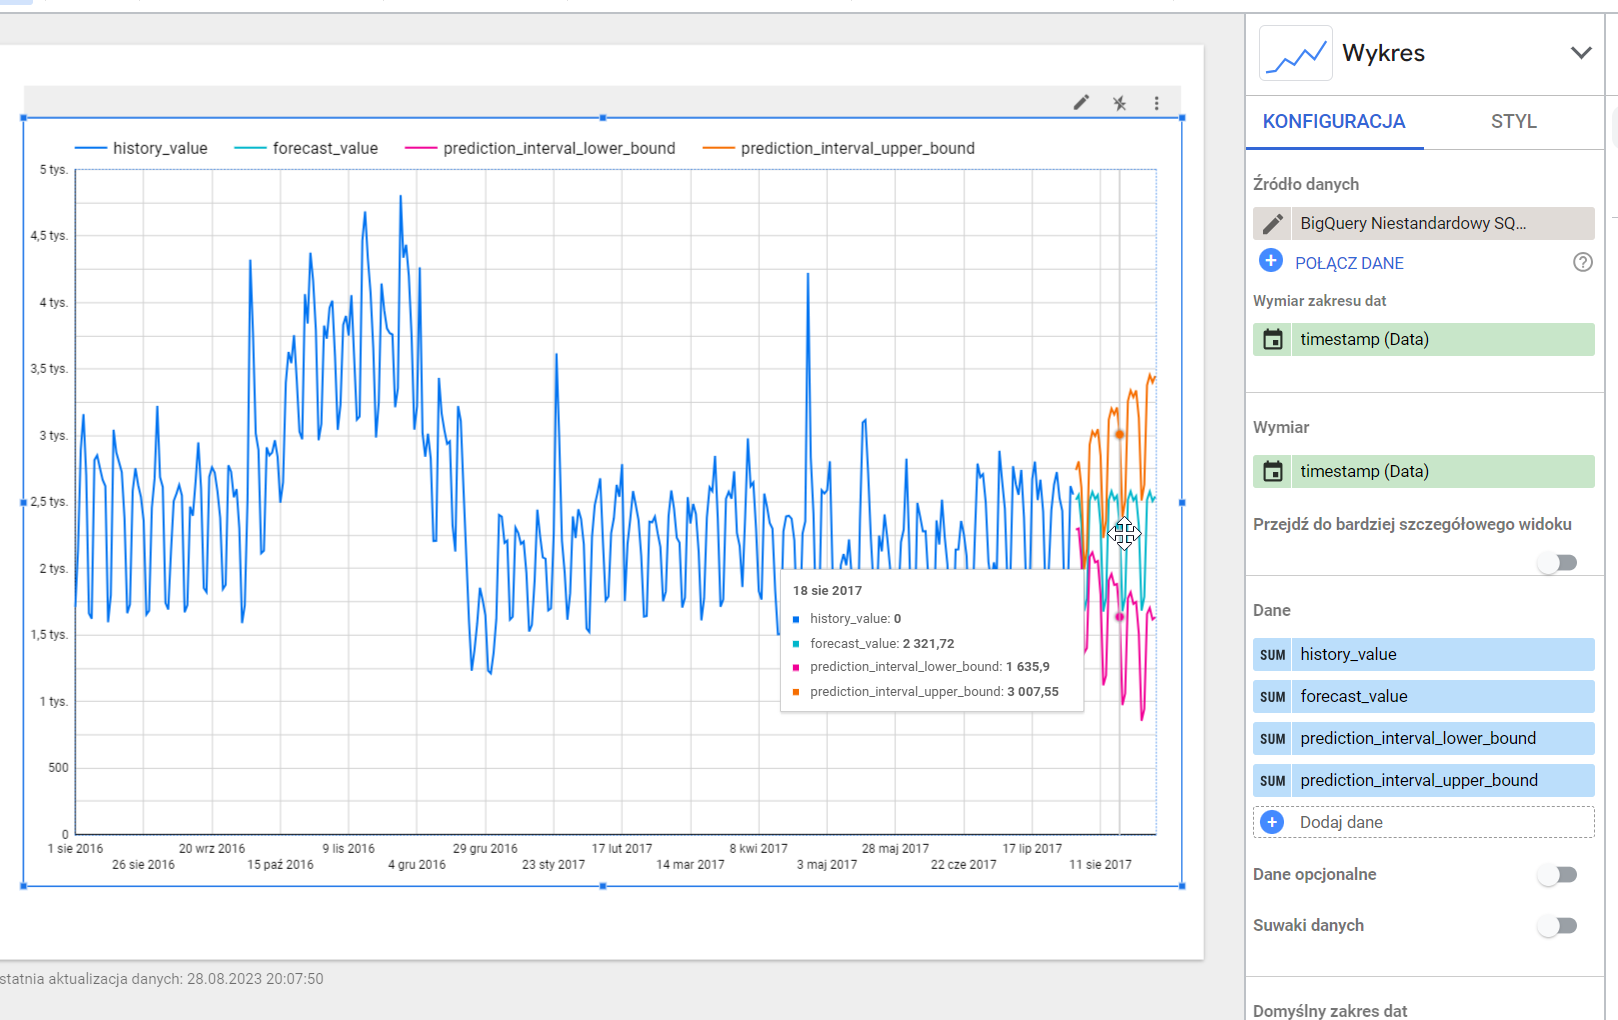

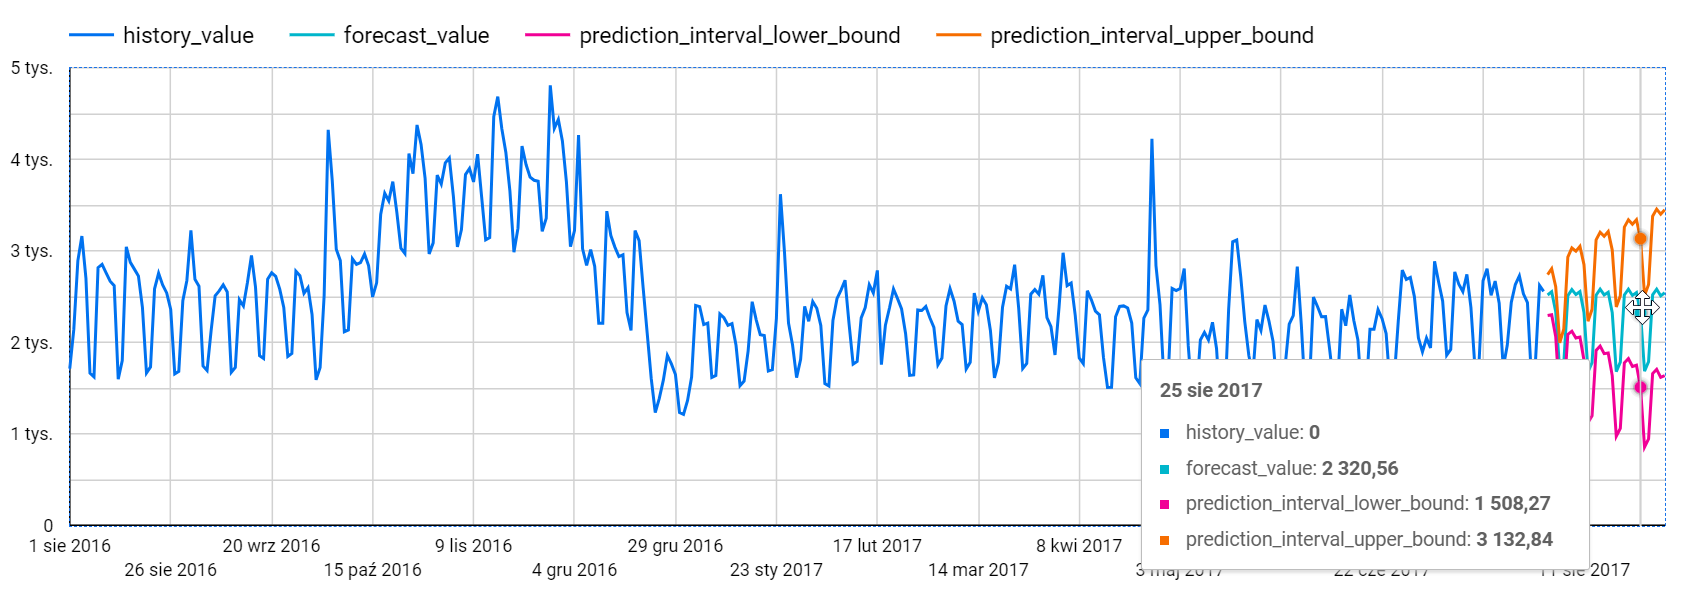